In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
import plotly.express as px
from io import BytesIO
import plotly.express as px
from skimage import io
from huggingface_hub import notebook_login
from PIL import Image, ImageDraw
from torchvision import transforms
from datasets import load_dataset, Dataset
import albumentations
import numpy as np
import torch
from transformers import AutoImageProcessor

/home/cameron/Documents/UBC Course Materials/2023W2/CPSC 440/license-plate-recognition/detr/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("keremberke/license-plate-object-detection", name="full")

In [3]:
ds["train"][0]

{'image_id': 6152,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 'width': 472,
 'height': 303,
 'objects': {'id': [6388],
  'area': [2604],
  'bbox': [[261.0, 203.0, 93.0, 28.0]],
  'category': [0]}}

In [4]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = ds["train"][0]["image"]
annotations = ds["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = ds["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

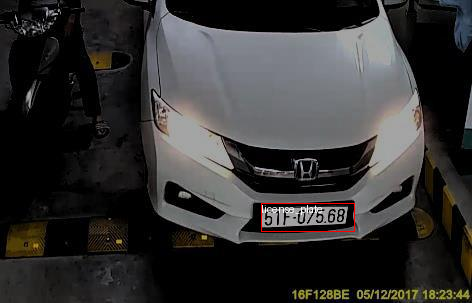

In [5]:
for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x)
        y1 = int(y)
        x2 = int((x + w))
        y2 = int((y + h))
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [6]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [7]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [8]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [9]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [10]:
ds["train"] = ds["train"].with_transform(transform_aug_ann)
ds["train"][15]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[ 0.1939,  0.1939,  0.1768,  ...,  0.3481,  0.3652,  0.3652],
          [ 0.1939,  0.1939,  0.1768,  ...,  0.3481,  0.3652,  0.3652],
          [ 0.1939,  0.1939,  0.1768,  ...,  0.3309,  0.3481,  0.3652],
          ...,
          [ 0.8789,  0.7591,  0.5878,  ..., -0.0287,  0.4166,  0.7248],
          [ 0.9988,  0.8447,  0.6221,  ...,  0.0912,  0.6221,  0.9646],
          [ 1.0673,  0.8961,  0.6392,  ...,  0.1768,  0.7591,  1.1358]],
 
         [[ 0.1702,  0.1702,  0.1527,  ...,  0.2402,  0.2577,  0.2577],
          [ 0.1702,  0.1702,  0.1527,  ...,  0.2402,  0.2577,  0.2577],
          [ 0.1702,  0.1702,  0.1527,  ...,  0.2227,  0.2402,  0.2577],
          ...,
          [ 1.0630,  0.9405,  0.7479,  ..., -0.1800,  0.2927,  0.6078],
          [ 1.0280,  0.8880,  0.6779,  ..., -0.0399,  0.5028,  0.8529],
          [ 0.9930,  0.8529,  0.6429,  ...,  0.0476,  0.6429,  1.0280]],
 
         [[ 0.3393,  0.3393,  0.3219,  ..., -0.0615, -0.0441, -0.0441],
          [ 

In [11]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [12]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_licence",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ds["train"],
    tokenizer=image_processor,
)

trainer.train()

/home/cameron/Documents/UBC Course Materials/2023W2/CPSC 440/Project/venv/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
50,2.702800
100,1.256300
150,0.901200
200,0.789700
250,0.848400
300,0.744900
350,0.748900
400,0.757600
450,0.760700
500,0.735400


TrainOutput(global_step=7720, training_loss=0.541530577877025, metrics={'train_runtime': 4781.3535, 'train_samples_per_second': 12.917, 'train_steps_per_second': 1.615, 'total_flos': 2.95091724312576e+19, 'train_loss': 0.541530577877025, 'epoch': 10.0})

In [13]:
import json


# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_detr_licence_annotation_file_images(test_licence):
    output_json = {}
    path_output_detr_licence = f"{os.getcwd()}/detr_licence/"

    if not os.path.exists(path_output_detr_licence):
        os.makedirs(path_output_detr_licence)

    path_anno = os.path.join(path_output_detr_licence, "detr_licence_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in test_licence:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(test_licence["image"], test_licence["image_id"]):
        path_img = os.path.join(path_output_detr_licence, f"{img_id}.png")
        im.save(path_img)

    return path_output_detr_licence, path_anno

In [7]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("./detr-resnet-50_finetuned_licence/checkpoint-7600")

path_output_licence, path_anno = save_detr_licence_annotation_file_images(ds["validation"])
test_ds_coco_format = CocoDetection(path_output_licence, im_processor, path_anno)

KeyboardInterrupt: 

In [17]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("./detr-resnet-50_finetuned_licence/checkpoint-7600")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to Pascal VOC format (xmin, ymin, xmax, ymax)

        module.add(prediction=results, reference=labels)
        # del batch

results = module.compute()

100%|█████████████████████████████████████████| 221/221 [40:17<00:00, 10.94s/it]


Accumulating evaluation results...
DONE (t=0.77s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.712
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.623
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.672
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [18]:
image = ds["test"][0]['image']

image_processor = AutoImageProcessor.from_pretrained("./detr-resnet-50_finetuned_licence/checkpoint-7600")
model = AutoModelForObjectDetection.from_pretrained("./detr-resnet-50_finetuned_licence/checkpoint-7600")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results_out = image_processor.post_process_object_detection(outputs, threshold=0.45, target_sizes=target_sizes)[0]

for score, label, box in zip(results_out["scores"], results_out["labels"], results_out["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-3.8513,  4.1646],
         [-3.8570,  4.0140],
         [-3.9404,  4.0050],
         [-3.5343,  3.2209],
         [-3.5213,  3.8376],
         [-3.3724,  4.0315],
         [-3.4105,  4.0220],
         [-3.5906,  4.2302],
         [-3.5836,  3.7989],
         [-3.5522,  3.8052],
         [-3.8208,  4.1190],
         [-3.8640,  4.0552],
         [-3.8126,  4.1874],
         [-3.7816,  4.0839],
         [-3.4002,  4.0245],
         [-3.6653,  3.9131],
         [-3.8476,  4.0844],
         [-4.0395,  4.0306],
         [-3.8712,  4.1297],
         [-4.0924,  4.1546],
         [-3.8093,  4.1139],
         [-3.8607,  4.1421],
         [-4.0043,  4.0743],
         [-3.7502,  4.0597],
         [-4.0487,  4.1332],
         [-3.9154,  4.1550],
         [-3.9032,  3.9397],
         [-3.3911,  4.1352],
         [-3.6137,  3.9051],
         [-3.8540,  4.1579],
         [-3.8484,  4.1344],
         [-3.4486,  4.0835],
         [-3

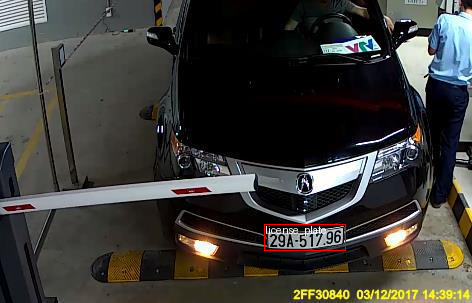

In [19]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results_out["scores"], results_out["labels"], results_out["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

## Compute Mean IoU

The repoted mean IoU: 0.8036143220273233

In [14]:
image_processor = AutoImageProcessor.from_pretrained("./detr-resnet-50_finetuned_licence/checkpoint-7600")
model = AutoModelForObjectDetection.from_pretrained("./detr-resnet-50_finetuned_licence/checkpoint-7600")

In [19]:
def get_data(data):
    images = []
    targets = []
    for i in range(0, len(data)):
        img = data[i]
        for j in range(len(img['objects']['bbox'])):
            box = img['objects']['bbox'][j]
            top_left_x = box[0]
            top_left_y = box[1]
            bottom_right_x = box[0] + box[2]
            bottom_right_y = box[1] + box[3]
        
            image = img['image']
        
            # convert image to array and append to list
            images.append(image)
        
            # apply relative scaling to bounding boxes as per given image and append to list
            targets.append(
                (
                    float(top_left_x),
                    float(top_left_y),
                    float(bottom_right_x),
                    float(bottom_right_y),
                )
            )
    return images, targets

In [20]:
x_test, y_test = get_data(ds["test"])

In [23]:
# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )

In [27]:
i, mean_iou = 0, 0

# Compare results for the test set
for image in x_test:
    print(i)
    with torch.no_grad():
        inputs = image_processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        results_out = image_processor.post_process_object_detection(outputs, threshold=0.25, target_sizes=target_sizes)[0]
    
    for score, label, preds in zip(results_out["scores"], results_out["labels"], results_out["boxes"]):
        preds = [round(j, 2) for j in preds.tolist()]
        # Predictions
        top_left_x, top_left_y = preds[0], preds[1]
        bottom_right_x, bottom_right_y = preds[2], preds[3]
        box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    
        # Test
        top_left_x, top_left_y = y_test[i][0], y_test[i][1]
        bottom_right_x, bottom_right_y = y_test[i][2], y_test[i][3]
        box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y
    
        mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27